# Prediksi Gagal Jantung

## Import Data

In [1]:
# Import library pengolahan struktur data
import pandas as pd

# Import library pengolahan angka
import numpy as np

In [2]:
## Bikin Fungsinya
def import_data(filename):
    """
    Fungsi import data dan hapus duplikat
    :param filename: string nama file.csv
    :return df: <pandas data frame> sampel data
    """
    
    # print nama file
    print("Source data : ",filename)
    
    # read data
    df = pd.read_csv(filename)
    print("Data asli : ",df.shape,"(observasi, kolom)")
    
    # hapus duplikat
    df = df.drop_duplicates()
    print("Data setelah drop dulikat :",df.shape,"(observasi, kolom)")
    
    #jangan lupa return
    return df
    
# state lokasi file
data_src = "/home/jovyan/work/project/heart_failure_clinical_records_dataset.csv"

# jalankan import data
heartfail_df = import_data(filename = data_src)

Source data :  /home/jovyan/work/project/heart_failure_clinical_records_dataset.csv
Data asli :  (299, 13) (observasi, kolom)
Data setelah drop dulikat : (299, 13) (observasi, kolom)


In [3]:
heartfail_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Data Preprocessing

### Input-output Split

In [4]:
# fungsi ekstrak
def extract_input_output(data, 
                         output_column_name):
    """
    Fungsi untuk memisahkan data input dan output, dengan hanya memasukkan data master dan kolom output
    :param data: <pandas data frame> data seluruh sample
    :param output_column_name: <string> nama kolom output
    :return input_data: <pandas dataframe> data input
    :return output_data: <pandas dataframe> data output
    """
    
    output_data = data[output_column_name]
    input_data = data.drop(output_column_name,
                           axis = 1)
    
    return input_data, output_data

x, y = extract_input_output(data = heartfail_df,
                            output_column_name = 'DEATH_EVENT')

### Train-test split

In [5]:
# Import train-test splitting library dari sklearn (scikit learn)
from sklearn.model_selection import train_test_split

# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.25,
                                                    random_state = 12)

In [6]:
# Sanity check hasil splitting
print(x_train.shape)
print(x_test.shape)

(224, 12)
(75, 12)


In [7]:
# Ratio
x_test.shape[0] / x.shape[0]

0.2508361204013378

In [8]:
x_train.isnull().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
dtype: bool

### Cek heatmap

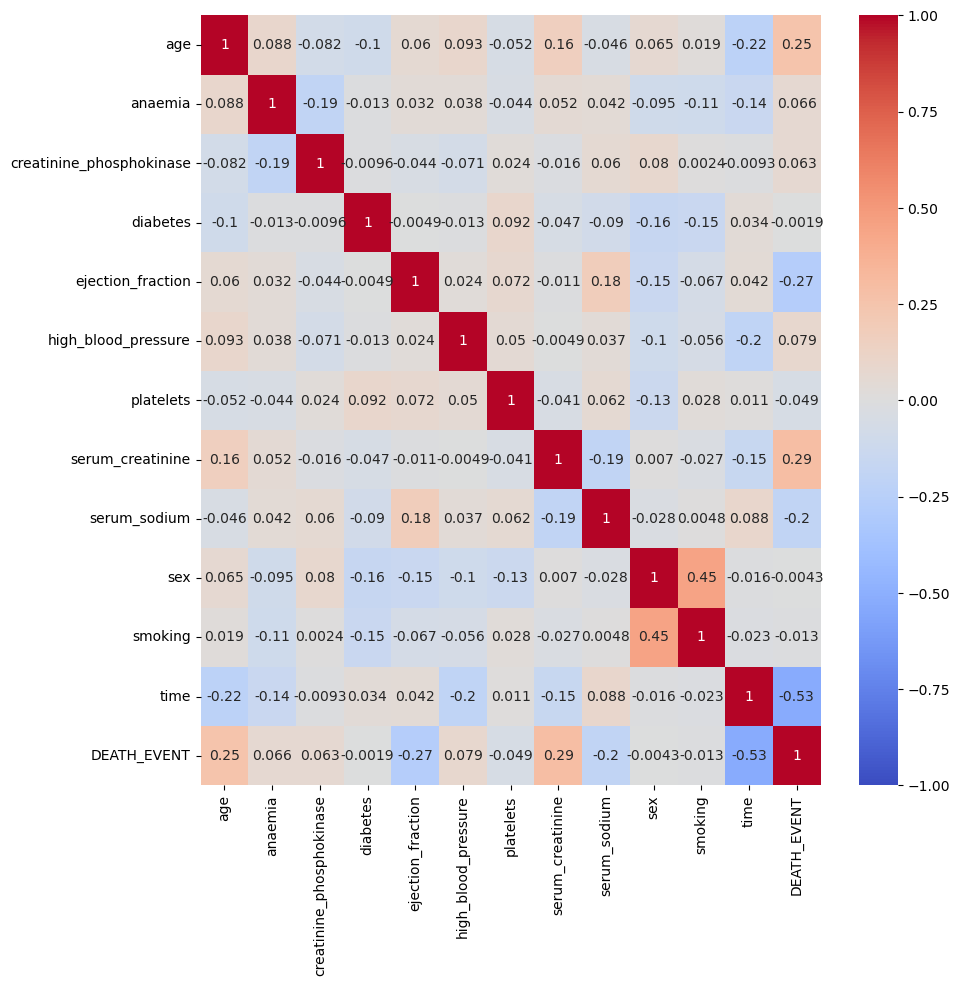

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(heartfail_df.corr(), vmin=-1, cmap='coolwarm', annot=True);

### Standarizer Variable

In [10]:
from sklearn.preprocessing import StandardScaler

# Buat fungsi
def standardizerData(data):
    """
    Fungsi untuk melakukan standarisasi data
    :param data: <pandas dataframe> sampel data
    :return standardized_data: <pandas dataframe> sampel data standard
    :return standardizer: method untuk standardisasi data
    """
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    # buat (fit) standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [11]:
x_train_clean, standardizer = standardizerData(data = x_train)

In [12]:
x_train_clean.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
205,-0.943131,1.123666,-0.446449,1.123666,0.653262,-0.723747,0.975605,-0.397082,-0.108976,-1.328696,-0.695301,0.732795
233,-0.690258,1.123666,0.123552,-0.889944,0.041731,-0.723747,0.658760,0.033964,0.119160,0.752618,1.438226,1.020198
38,-0.100221,-0.889944,2.180832,1.123666,-0.657162,-0.723747,0.411225,1.003818,0.119160,0.752618,-0.695301,-1.318215
24,1.164144,-0.889944,-0.008393,1.123666,-0.657162,1.381699,-0.001089,0.497339,-0.565247,-1.328696,-0.695301,-1.409661
178,0.152652,1.123666,-0.493949,1.123666,1.963687,-0.723747,0.034972,-0.181559,1.944247,0.752618,-0.695301,0.210245


## Training Model

In [13]:
y_train.value_counts(normalize = True)

0    0.6875
1    0.3125
Name: DEATH_EVENT, dtype: float64

In [14]:
# Import dari sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Model K nearest neighbor
knn = KNeighborsClassifier()
knn.fit(x_train_clean, y_train)

KNeighborsClassifier()

In [16]:
# Model Logistic Regression
logreg = LogisticRegression(random_state = 123)
logreg.fit(x_train_clean, y_train)

LogisticRegression(random_state=123)

In [17]:
# Model Random Forest Classifier
random_forest = RandomForestClassifier(random_state = 123)
random_forest.fit(x_train_clean, y_train)

RandomForestClassifier(random_state=123)

### Prediction

In [18]:
predicted_logreg = pd.DataFrame(logreg.predict(x_train_clean))
predicted_logreg.head()

,0
0,0
1,0
2,1
3,1
4,0


In [19]:
predicted_knn = pd.DataFrame(knn.predict(x_train_clean))
predicted_knn.head()

,0
0,0
1,0
2,0
3,1
4,0


In [20]:
predicted_rf = pd.DataFrame(random_forest.predict(x_train_clean))
predicted_rf.head()

,0
0,0
1,0
2,0
3,1
4,0


In [21]:
benchmark = y_train.value_counts(normalize=True)[0]
benchmark

0.6875

In [22]:
# akurasi knn
knn.score(x_train_clean, y_train)

0.8035714285714286

In [23]:
# akurasi logistic regression
logreg.score(x_train_clean, y_train)

0.8303571428571429

In [24]:
# akurasi random forest
random_forest.score(x_train_clean, y_train)

1.0

### Save ke Pickle

In [25]:
import joblib

# Simpan model logreg ke dalam folder yang sama dengan notebook
# dengan nama logreg.pkl
joblib.dump(logreg, "logreg.pkl")

joblib.dump(knn, "knn.pkl")

joblib.dump(random_forest, "random_forest.pkl")
#joblib.dump(random_forest_1, "random_forest_1.pkl")

['random_forest.pkl']

In [26]:
def extract_test(data, standardizer):
    cleaned_data = pd.DataFrame(standardizer.transform(data))
    cleaned_data.columns = data.columns
    
    return cleaned_data

In [27]:
def testPrediction(x_test, y_test, classifier, compute_score):
    """
    Fungsi untuk mendapatkan prediksi dari model
    :param X_test: <pandas dataframe> input
    :param y_test: <pandas series> output/target
    :param classifier: <sklearn method> model klasifikasi
    :param compute_score: <bool> True: menampilkan score, False: tidak
    :return test_predict: <list> hasil prediksi data input
    :return score: <float> akurasi model
    """
    if compute_score:
        score = classifier.score(x_test, y_test)
        print(f"Accuracy : {score:.4f}")

    test_predict = classifier.predict(x_test)

    return test_predict, score

In [28]:
x_test_clean = extract_test(data = x_test,
                           standardizer = standardizer)

In [29]:
x_test_clean.shape

(75, 12)

In [30]:
x_test_clean

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,-1.617459,1.123666,-0.531949,-0.889944,-0.220354,-0.723747,1.005309,-0.289321,0.575432,0.752618,1.438226,0.915688
1,1.164144,-0.889944,-0.008393,-0.889944,0.216454,-0.723747,-0.001089,-0.203111,0.119160,0.752618,-0.695301,-0.312306
2,0.911271,1.123666,-0.506615,-0.889944,-1.093971,-0.723747,0.104282,-0.397082,0.803568,0.752618,1.438226,-0.860983
3,-0.184512,1.123666,-0.486560,-0.889944,0.653262,1.381699,0.975605,-0.289321,0.575432,0.752618,1.438226,-0.129413
4,-0.943131,-0.889944,-0.008393,-0.889944,2.138410,1.381699,-1.153196,-0.612605,0.803568,0.752618,1.438226,0.798114
...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.690258,-0.889944,-0.415838,-0.889944,1.963687,-0.723747,-0.430394,-0.720367,-0.793383,0.752618,1.438226,0.040416
71,0.068361,1.123666,0.068663,-0.889944,0.216454,-0.723747,0.193394,-0.720367,-0.793383,-1.328696,-0.695301,1.333728
72,1.164144,-0.889944,-0.497115,-0.889944,1.090070,1.381699,-0.153155,-0.289321,2.628654,0.752618,-0.695301,1.020198
73,0.911271,1.123666,0.372663,-0.889944,-1.093971,1.381699,0.737971,0.357249,0.575432,0.752618,1.438226,-0.260050


In [31]:
# Logistic Regression Performance
logreg_test_predict, score = testPrediction(x_test = x_test_clean,
                                            y_test = y_test,
                                            classifier = logreg,
                                            compute_score = True)

Accuracy : 0.8000


In [32]:
# K nearest neighbor Performance
knn_test_predict, score = testPrediction(x_test = x_test_clean,
                                        y_test = y_test,
                                        classifier = knn,
                                        compute_score = True)

Accuracy : 0.7067


In [33]:
# Random Forest Performance
rf_test_predict, score = testPrediction(x_test = x_test_clean,
                                        y_test = y_test,
                                        classifier = random_forest,
                                        compute_score = True)

Accuracy : 0.8667
